# Hit Maker Predictor

Model Objective: Predict whether a song will chart on Billboard using musical and promotional features.

## Initialisation

Import packages and perform data cleaning

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from dmba import textDecisionTree
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # Create the parameter grid based on the results of random search 

import matplotlib.pyplot as plt
%matplotlib inline 
# tells VS Code to display plots inside the interface

In [10]:
# Import main dataset
spotify_df = pd.read_csv("spotify_2023_peak_cleaned.csv")

# Identify problematic rows
invalid_streams = spotify_df[~spotify_df['streams'].str.replace(',', '').str.isnumeric()]
print(invalid_streams[['track_name', 'streams']])

                              track_name  \
574  Love Grows (Where My Rosemary Goes)   

                                               streams  
574  BPM110KeyAModeMajorDanceability53Valence75Ener...  


In [11]:
# Drop the problematic row by index
spotify_df = spotify_df.drop(index=574).reset_index(drop=True)

In [12]:
# Convert cleaned string to int (remove commas if any)
for col in ['streams', 'in_deezer_playlists', 'in_shazam_charts']:
    spotify_df[col] = spotify_df[col].astype(str).str.replace(',', '').str.replace('–', '0')
    spotify_df[col] = pd.to_numeric(spotify_df[col], errors='coerce').fillna(0).astype(int)

## Exploratory data analysis (EDA)

In [9]:
#EDA

spotify_df.info()

spotify_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               953 non-null    int64  
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    int64  
 12  in_deezer_charts      953 non-null    int64  
 13  in_shazam_charts      953 non-null    int64  
 14  bpm                   953 non-null    int64  
 15  key                   8

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,charted_billboard,days_to_peak
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,9.530000e+02,953.000000,953.000000,953.000000,...,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,5.135979e+08,67.812172,51.908709,385.187828,...,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165,0.551941,1548.211962
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,5.668039e+08,86.441493,50.630241,1130.535561,...,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888,0.497556,3922.309893
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,1.413817e+08,13.000000,7.000000,13.000000,...,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000,0.000000,46.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,2.902286e+08,34.000000,38.000000,44.000000,...,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000,1.000000,296.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,6.738011e+08,88.000000,87.000000,164.000000,...,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000,1.000000,842.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.703895e+09,672.000000,275.000000,12367.000000,...,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000,1.000000,29935.000000


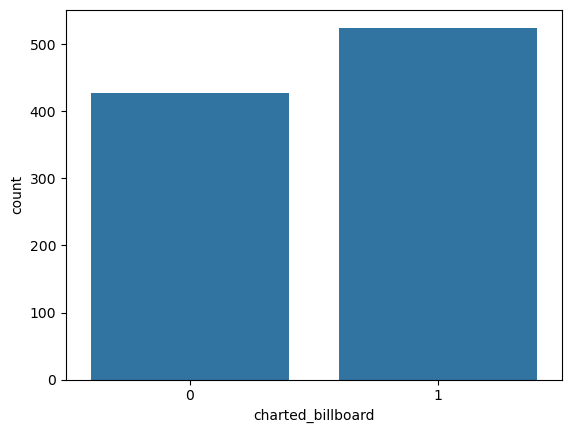

In [15]:
# Counting the output variable
sns.countplot(x='charted_billboard',data=spotify_df) # frequency of categories in the target variable

# define target (y1) columns
# Target variable
y1cols = ['charted_billboard']
y1 = spotify_df[y1cols]

## Model 1: Full Feature Model (18 variables)

This model uses all relevant predictors 
Goal: Maximize performance using the full picture

In [20]:
# define predictor (X1) columns
X1cols_model1 = [
    'in_spotify_playlists', 'in_spotify_charts', 'streams',
    'in_apple_playlists', 'in_apple_charts',
    'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts',
    'bpm', 'danceability_%', 'valence_%', 'energy_%',
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%',
    'artist_count', 'days_to_peak'
]
X1 = spotify_df[X1cols_model1]

<Axes: >

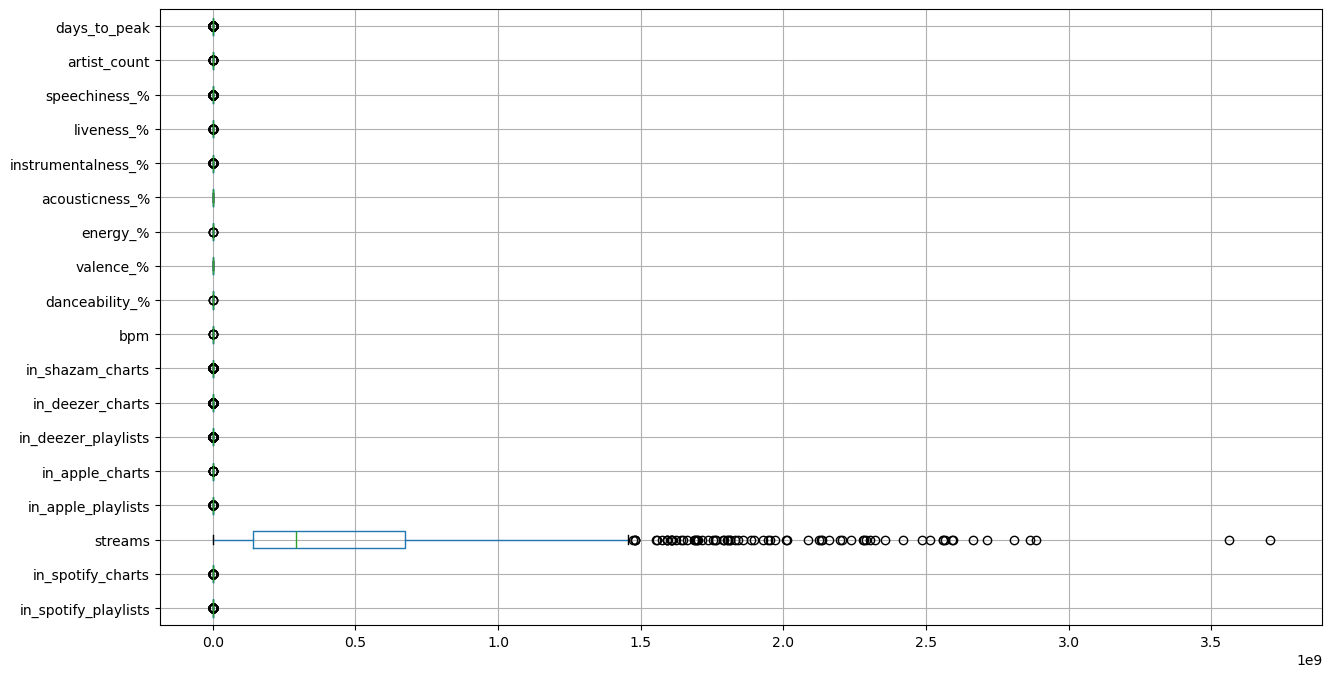

In [29]:
# EDA
X1_numeric_data = X1.select_dtypes(include=[np.number])
X1_numeric_data.boxplot(vert=False,figsize=(15,8))


array([[<Axes: title={'center': 'in_spotify_playlists'}>,
        <Axes: title={'center': 'in_spotify_charts'}>,
        <Axes: title={'center': 'streams'}>,
        <Axes: title={'center': 'in_apple_playlists'}>],
       [<Axes: title={'center': 'in_apple_charts'}>,
        <Axes: title={'center': 'in_deezer_playlists'}>,
        <Axes: title={'center': 'in_deezer_charts'}>,
        <Axes: title={'center': 'in_shazam_charts'}>],
       [<Axes: title={'center': 'bpm'}>,
        <Axes: title={'center': 'danceability_%'}>,
        <Axes: title={'center': 'valence_%'}>,
        <Axes: title={'center': 'energy_%'}>],
       [<Axes: title={'center': 'acousticness_%'}>,
        <Axes: title={'center': 'instrumentalness_%'}>,
        <Axes: title={'center': 'liveness_%'}>,
        <Axes: title={'center': 'speechiness_%'}>],
       [<Axes: title={'center': 'artist_count'}>,
        <Axes: title={'center': 'days_to_peak'}>, <Axes: >, <Axes: >]],
      dtype=object)

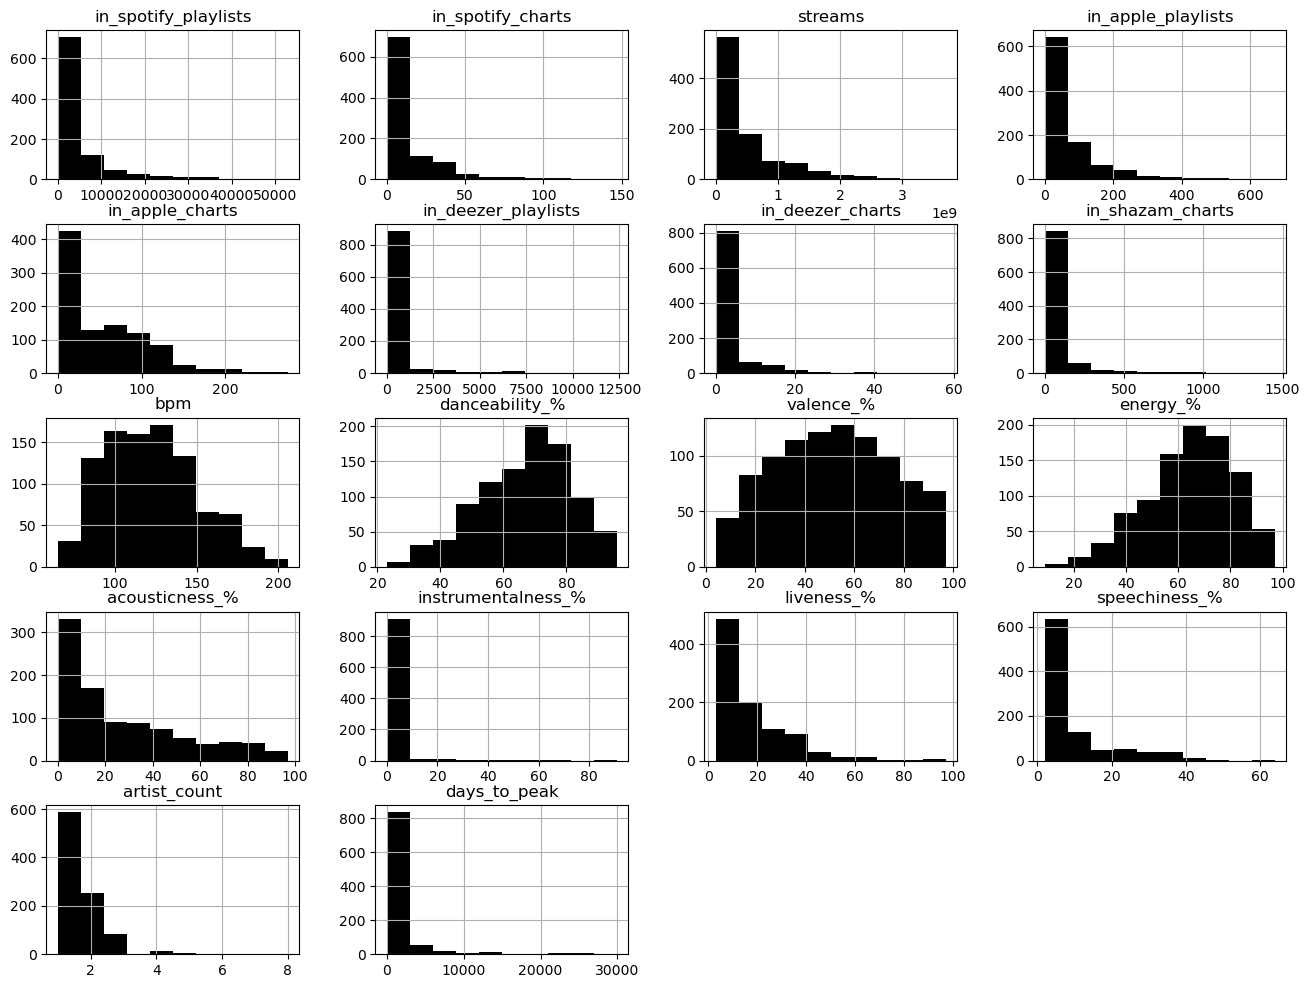

In [61]:
X1.hist(color='black',figsize=(16,12))


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


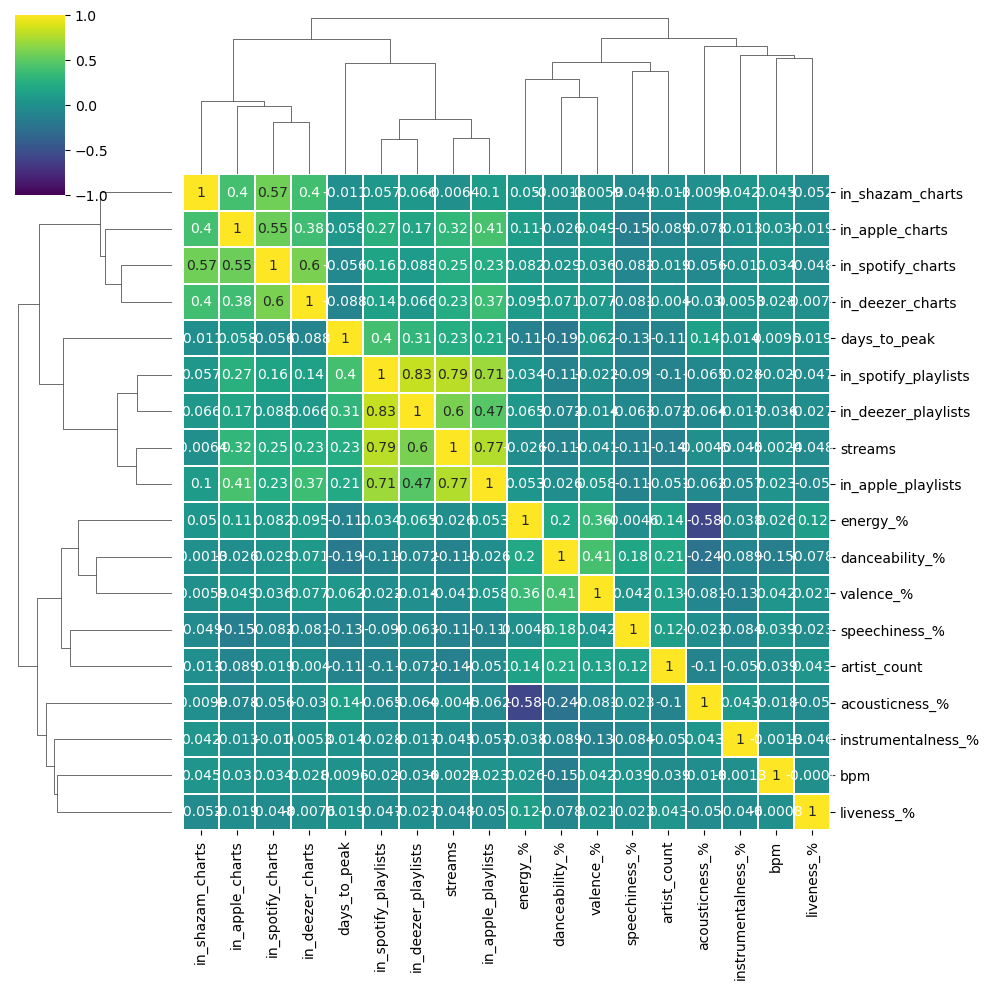

In [39]:
# calculate correlation matrix between all variables. Defaults to Pearson's r correlation
corr = X1.corr()

# hierarchically-clustered heatmap of correlation matrix to understand the association between variables
sns.clustermap(corr, center=0,cmap=plt.get_cmap('viridis'),
            square=True, linewidths=.05, annot=True, vmin=-1, vmax=1) 


## Model 2: Reduced Feature Model (5 variables)
Uses a subset of variables based on Exploratory Data Analysis findings and logic, considering what labels might look at -- playlists & virality.

Goal: Retain performance with fewer inputs to reduce noise and improve interpretability.

In [55]:
X1cols_model2 = [
    'in_spotify_playlists', #A good proxy for Spotify promotion reach
    'in_shazam_charts', #Only weakly correlated with other features, radio promotion proxy
    'artist_count', #may indicate collaborative buzz
    'danceability_%', 'valence_%', #Capture musical feel, likely valuable for hits
    'days_to_peak' #may reflect TikTok or viral timing
]
X2 = spotify_df[X1cols_model2]

<Axes: >

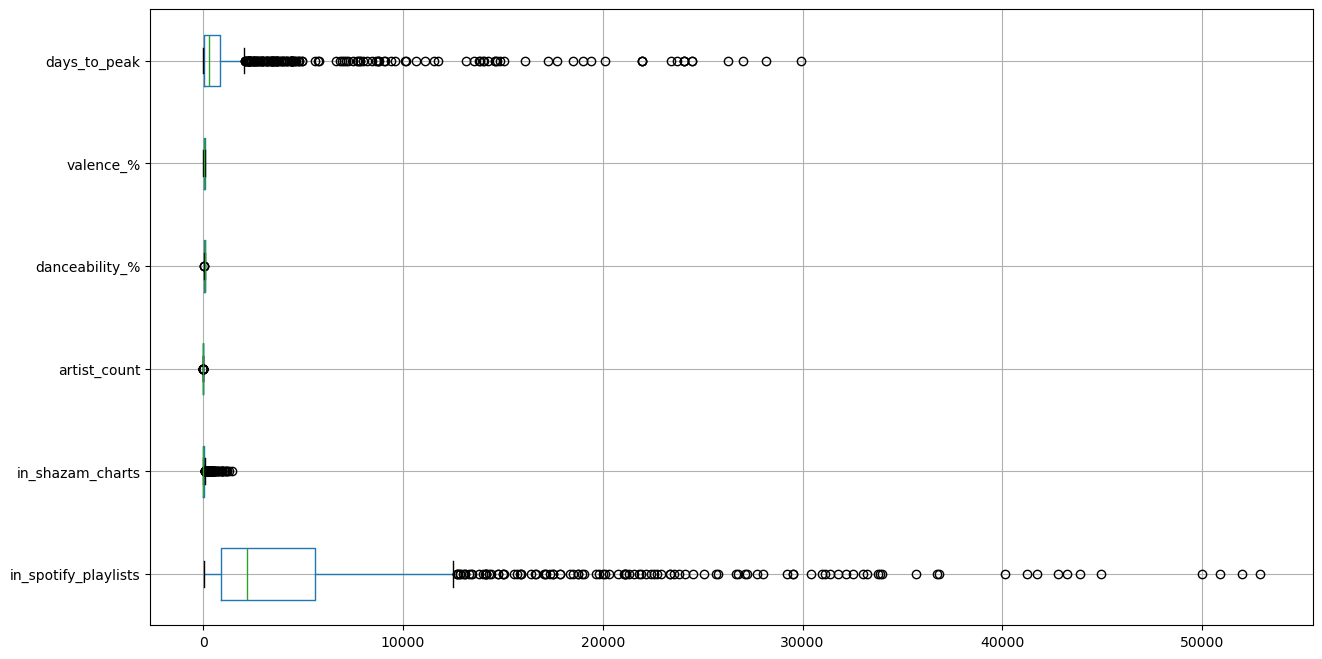

In [41]:
# EDA
X2_numeric_data = X2.select_dtypes(include=[np.number])
X2_numeric_data.boxplot(vert=False,figsize=(15,8))

## Model Comparison

In [66]:
# === Model 1: Full Feature Set ===
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)




In [ ]:
param_grid = {
    'max_depth': [10, 40],
    'n_estimators': [100, 200, 300] # restricted the grid search to reduce compute time 
}
# Create a based model
model = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3 # number of folds for cross validation
                           , n_jobs = -1 # use all processors
                            , verbose = 2 # what to display
                          )

grid_search.fit(X1, y1)
model = grid_search.best_estimator_
y2_pred=model.predict(X1)
print ('The out of sample test accuracy for a RandomForestClassifier is : '+ str(round(accuracy_score(y1_test, y2_pred),3)))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=40, n_estimators=100; total time=   0.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 

[CV] END .....................max_depth=40, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=300; total time=   0.4s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s
[CV] END .....................max_depth=40, n_estimators=300; total time=   0.3s


/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: RandomForestClassifier(max_depth=40, n_estimators=300)
The out of sample test accuracy for a RandomForestClassifier is : 0.749


In [ ]:

rf1 = RandomForestClassifier(n_estimators=100, max_depth=40, random_state=42)
rf1.fit(X1_train, y1_train)
y1_pred = rf1.predict(X1_test)


Model 1 (Full Feature Set)
Accuracy: 0.7643979057591623
              precision    recall  f1-score   support

           0       0.76      0.66      0.71        82
           1       0.77      0.84      0.80       109

    accuracy                           0.76       191
   macro avg       0.76      0.75      0.75       191
weighted avg       0.76      0.76      0.76       191



/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


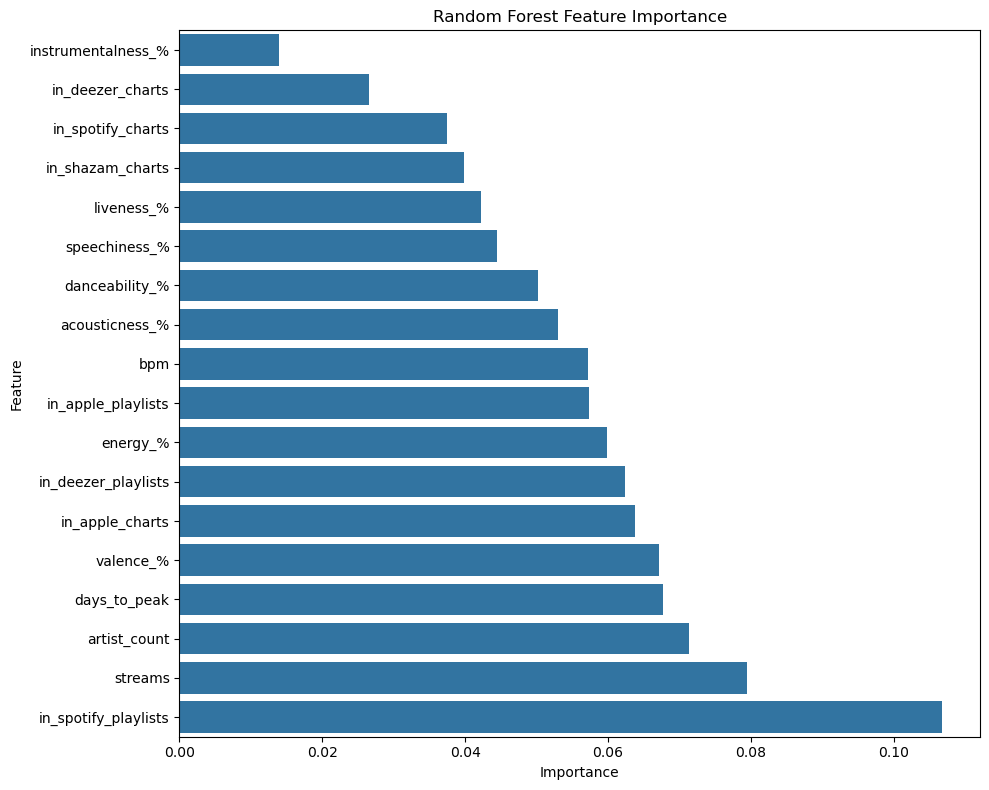

In [46]:
importances = rf1.feature_importances_
feat_df = pd.DataFrame({'Feature': X1cols_model1, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_df, x='Importance', y='Feature')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [56]:
# === Model 2: Reduced Feature Set ===
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y1, test_size=0.2, random_state=42)

rf2 = RandomForestClassifier(n_estimators=100, max_depth=40, random_state=42)
rf2.fit(X2_train, y2_train)
y2_pred = rf2.predict(X2_test)

print("Model 2 (Reduced Feature Set)")
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Model 2 (Reduced Feature Set)
Accuracy: 0.7225130890052356
              precision    recall  f1-score   support

           0       0.68      0.67      0.67        82
           1       0.75      0.76      0.76       109

    accuracy                           0.72       191
   macro avg       0.72      0.72      0.72       191
weighted avg       0.72      0.72      0.72       191



/opt/anaconda3/envs/envGEOG0178/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


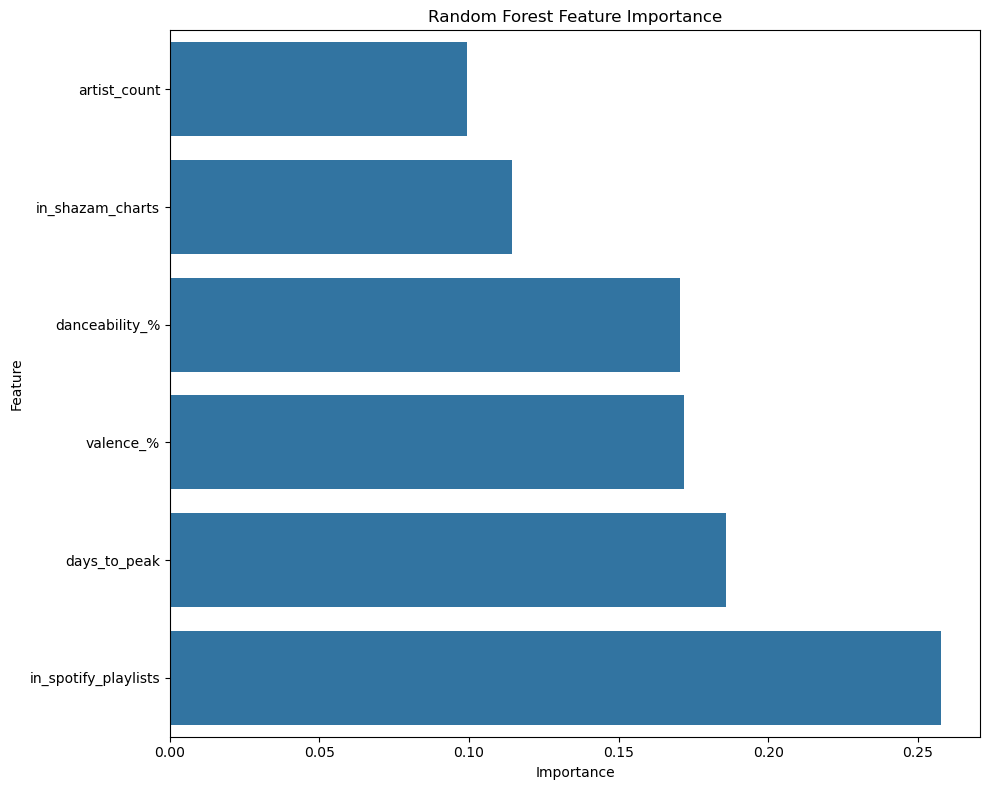

In [57]:
importances = rf2.feature_importances_
feat_df = pd.DataFrame({'Feature': X1cols_model2, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_df, x='Importance', y='Feature')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [59]:
report1 = classification_report(y1_test, y1_pred, output_dict=True)
report2 = classification_report(y2_test, y2_pred, output_dict=True)

# Grab relevant metrics for charted songs
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
model1_scores = [
    report1['accuracy'],
    report1['1']['precision'],
    report1['1']['recall'],
    report1['1']['f1-score']
]

model2_scores = [
    report2['accuracy'],
    report2['1']['precision'],
    report2['1']['recall'],
    report2['1']['f1-score']
]


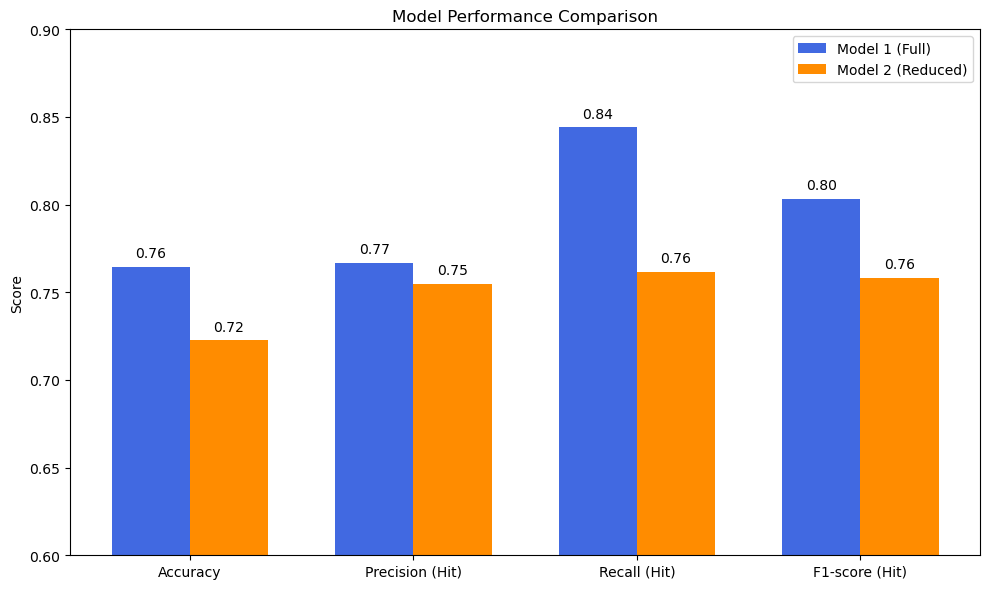

In [60]:
labels = ['Accuracy', 'Precision (Hit)', 'Recall (Hit)', 'F1-score (Hit)']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, model1_scores, width, label='Model 1 (Full)', color='royalblue')
bar2 = ax.bar(x + width/2, model2_scores, width, label='Model 2 (Reduced)', color='darkorange')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.6, 0.9)
ax.legend()

# Add value labels
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()